
## Random Forest and Balanced Random Forest for Subsurface Classification in Python

#### Haoyu Wang
#### Department of Geography and the Environment

### Subsurface Machine Learning Course, The University of Texas at Austin
#### Hildebrand Department of Petroleum and Geosystems Engineering, Cockrell School of Engineering
#### Department of Geological Sciences, Jackson School of Geosciences




_____________________

Workflow supervision and review by:

#### Instructor: Prof. Michael Pyrcz, Ph.D., P.Eng., Associate Professor, The Univeristy of Texas at Austin
##### [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

#### Course TA: Misael Morales, Graduate Student, The University of Texas at Austin
##### [LinkedIn](https://www.linkedin.com/in/misaelmmorales/)


### Executive Summary
This workflow aims to explore how Balanced Random Forest algorithm helps to classify low production and high production wells.  This imbalanced data characteristic occur frequently in response feature such as production of wells and potential oil leaks in the field of spatial data science. We used both Random Forest and Balanced Random Forest for classification after 
adding Gaussian noise and setting the random seed. A 70%/30% train/test split was done to assess the classification accuracy. We observe that the classification of high/low production is balanced and the precision and recall scores improved. We recommend to use the Balanced Random Forest in this workflow for learning subsurface dataset that having imbalanced labels associated with the response.

### Import Packages
We need to install additional package named "imblearn" to import the Balanced Random Forest classifier: 

In [1]:
# !pip install imblearn                                     # to install imblearn for imbalanced machine learning

In [2]:
import os                                                   # to set current working directory 
import math                                                 # basic calculations like square root
import pandas as pd                                         # DataFrames and plotting
import numpy as np                                          # arrays and matrix math
import pandas.plotting as pd_plot
import matplotlib.pyplot as plt                             # plotting
from sklearn.ensemble import RandomForestClassifier         # Random Forest method
from imblearn.ensemble import BalancedRandomForestClassifier# Balanced Random Forest method
from sklearn.model_selection import train_test_split        # to generate train/test datasets
from sklearn.metrics import classification_report,confusion_matrix # to generate confusion matrix and classification report
import seaborn as sns                                       # import seaborn color hues
cmap = plt.cm.inferno                                       # great color map

### Functions

The following functions will be used in the workflow:

The first two functions in the following code block are from Professor Michael Pyrcz (@GeostatsGuy), SubsurfaceDataAnalytics_EnsembleTrees.ipynb from [GeostatsGuy GitHub](https://github.com/GeostatsGuy/PythonNumericalDemos/blob/master/SubsurfaceDataAnalytics_EnsembleTrees.ipynb).

In [3]:
def visualize_model(model,xfeature,x_min,x_max,yfeature,y_min,y_max,response,z_min,z_max,title,):# plots the data points and the decision tree prediction 
    cmap = plt.cm.inferno
    xplot_step = (x_max - x_min)/300.0; yplot_step = (y_max - y_min)/300.0 # resolution of the model visualization
    xx, yy = np.meshgrid(np.arange(x_min, x_max, xplot_step), # set up the mesh
                     np.arange(y_min, y_max, yplot_step))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])      # predict with our trained model over the mesh
    Z = Z.reshape(xx.shape)
    im = plt.imshow(Z,interpolation = None,aspect = "auto",extent = [x_min,x_max,y_min,y_max], vmin = z_min, vmax = z_max,cmap = cmap)
    if (type(xfeature) != str) & (type(yfeature) != str):
        plt.scatter(xfeature,yfeature,s=None, c=response, marker=None, cmap=cmap, norm=None, vmin=z_min, vmax=z_max, alpha=1.0, linewidths=0.6, edgecolors="white")
        plt.xlabel(xfeature.name); plt.ylabel(yfeature.name)
    else:
        plt.xlabel(xfeature); plt.ylabel(yfeature)
    plt.title(title)                                       # add the labels

    plt.xlim([x_min,x_max]); plt.ylim([y_min,y_max])
    cbar = plt.colorbar(im, orientation = 'vertical')      # add the color bar
    if type(response) == str:
        cbar.set_label(response, rotation=270, labelpad=20)        
    else:
        cbar.set_label(response.name, rotation=270, labelpad=20)
    return Z

    
def check_model(model,xfeature,yfeature,response,title):    # plots the estimated vs. the actual  
    predict_train = model.predict(np.c_[xfeature,yfeature])
    plt.scatter(response,predict_train,s=None, c='red',marker=None, cmap=cmap, norm=None, vmin=None, vmax=None, alpha=0.2, linewidths=0.3, edgecolors="black")
    plt.title(title); plt.xlabel('Actual Production (MCFPD)'); plt.ylabel('Estimated Production (MCFPD)')
    plt.xlim(0,1); plt.ylim(0,7000)
    plt.arrow(0,0,7000,7000,width=0.02,color='black',head_length=0.0,head_width=0.0)
    MSE = metrics.mean_squared_error(response,predict_train)
    Var_Explained = metrics.explained_variance_score(response,predict_train)
    cor = math.sqrt(metrics.r2_score(response,predict_train))
    print('Mean Squared Error on Training = ', round(MSE,2),', Variance Explained =', round(Var_Explained,2),'Cor =', round(cor,2))

def plot_cmatrix(model_is,y_test,y_pred,cmap):  # plots confusion matrix for models
    matrix = confusion_matrix(y_test, y_pred)
    sns.heatmap(matrix, annot=True, annot_kws={'size':20},fmt='g',cmap=cmap, linewidths=0.2)
    prod_labels = ['Low', 'High']
    plt.xticks(np.arange(len(prod_labels)), prod_labels, rotation=25)
    plt.yticks(np.arange(len(prod_labels))+0.5, prod_labels, rotation=0)
    plt.xlabel('Predicted Production Level')
    plt.ylabel('True Production Level')
    plt.title('Confusion Matrix Using ' + model_is)
    return plt

### Load Data

The following workflow applies the .csv file '.csv', The dataset is publically available [here](https://github.com/GeostatsGuy/GeoDataSets/blob/master/unconv_MV.csv)  

We will work with the following predictors:

1. well average porosity (%) 
2. permeability (mD)
3. accoustic impedance (kg/m2s*10^6)
4. brittness ratio (%) 
5. total organic carbon (%) 
6. vitrinite reflectance (%)

And the response feature: 

7. normalized initial production 90 day average (MCFPD) encoded to "low prodcution (0)" and "high production (1)". 

### Introduction
Certain restrictions exist to learn imbalanced data such as a small portion of high production and a large numbers of low production wells by Random Forest. One of the reasons is that Random Forest uses a bootstrap sample of the training set for fitting each tree. The probability of bootstrap sampling to sample the minor classes will decrease, which makes the model to bias towards the majority classes. 

To address this issue from Random Forest, we fit Balanced Random Forest model to do machine learning classification on data derived from production of unconventional wells, and 
it is important to sample equal classes by downsampling or oversampling as proposed by Balanced Random Forest model through iteratively drawing bootstrap samples with equal proportions of data from both high and low production classes.

This workflow was inspired by the paper published by Chen et al in 2004, where you can find it at: 
 [Chen, Chao, Andy Liaw, and Leo Breiman. “Using random forest to learn imbalanced data.” University of California, Berkeley 110 (2004): 1-12.](https://statistics.berkeley.edu/sites/default/files/tech-reports/666.pdf)

The code blocks that import the data and fit to random forest model in the following code blocks are from Professor Michael Pyrcz (@GeostatsGuy), SubsurfaceDataAnalytics_EnsembleTrees.ipynb from [GeostatsGuy GitHub](https://github.com/GeostatsGuy/PythonNumericalDemos/blob/master/SubsurfaceDataAnalytics_EnsembleTrees.ipynb).

We first read in the unconventional wells production data and add random errors to the data: 

In [4]:
my_data = pd.read_csv(r"https://raw.githubusercontent.com/GeostatsGuy/GeoDataSets/master/unconv_MV.csv")# load the comma delimited data file

In [5]:
std_error = 500
my_data['Production'] = my_data['Production'] + np.random.normal(loc = 0.0,scale=std_error,size=len(my_data)) # add noise

# prevent negative production weith truncation
num = my_data._get_numeric_data()                         # get the numerical values
num[num < 0] = 0                                          # truncate negative values to 0.0
my_data.describe().transpose()                            # calculate summary statistics for the data

,count,mean,std,min,25%,50%,75%,max
WellIndex,1000.0,500.500000,288.819436,1.00,250.750000,500.500000,750.250000,1000.000000
Por,1000.0,14.950460,3.029634,5.40,12.857500,14.985000,17.080000,24.650000
LogPerm,1000.0,1.398880,0.405966,0.12,1.130000,1.390000,1.680000,2.580000
AI,1000.0,2.982610,0.577629,0.96,2.577500,3.010000,3.360000,4.700000
Brittle,1000.0,49.731480,15.033593,0.00,39.722500,49.680000,59.170000,93.470000
TOC,1000.0,1.006170,0.499838,0.00,0.640000,0.995000,1.360000,2.710000
VR,1000.0,1.991170,0.308194,0.90,1.810000,2.000000,2.172500,2.900000
Production,1000.0,2264.291542,1519.976751,0.00,1159.782926,2038.663872,3131.804304,12279.782454


Examine data scatter plot and distribution of production values, especially production distribution to decide on an arbitrary cut-off to make a classification-available response feature: 

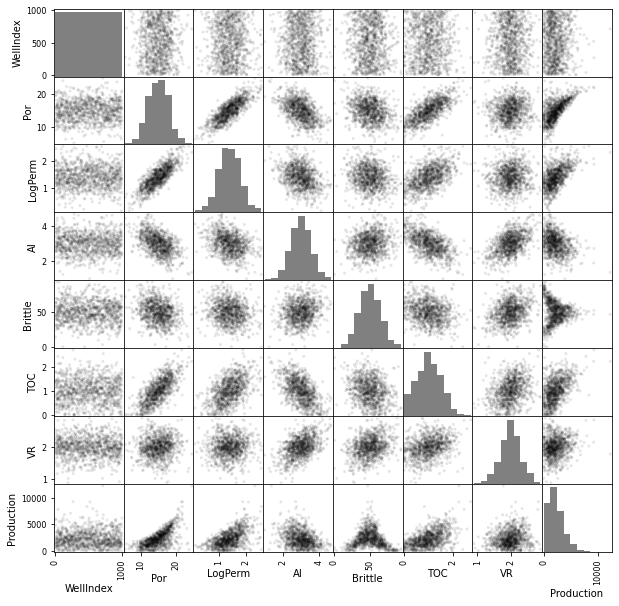

In [6]:
pd_plot.scatter_matrix(my_data, alpha = 0.1,                # pandas matrix scatter plot
    figsize=(10, 10),color = 'black', hist_kwds={'color':['grey']})
plt.show()

We want to do a classification on two classes of production. According to the histogram above, I manually decide a cut-off at 5,000 MCFPD on production to classify it into two labels to make the classification comparisons: 

In [7]:
# manually define an imbalanced production
my_data.loc[my_data['Production'] < 5000, 'Production'] = 0
my_data.loc[my_data['Production'] >= 5000, 'Production'] = 1
my_data.describe().transpose()    

len(my_data.loc[my_data['Production']>0,])/len(my_data)


0.051

We split a 70% and 30% train and test data using all six predictor variables: 

In [8]:
X_train, X_test, y_train, y_test = train_test_split(my_data[['Por','TOC','VR','LogPerm','AI','Brittle']], #,'TOC','VR','LogPerm','AI',
                                                    my_data[['Production']], test_size = 0.3)

We set the hyperparameters and generate the same seed for both Random Forest and Balanced Random Forest, and fit both models using the same set of training data: 

In [9]:
# set the random forest hyperparameters
seed = 78731                                                
max_depth = 7
num_tree = 300
max_features = 1

In [10]:
# fit random forest model
random_forest = RandomForestClassifier(max_depth=max_depth, random_state=seed,n_estimators=num_tree, max_features=max_features, oob_score = True, n_jobs = 4)
random_forest.fit(X = X_train, y = y_train.values.ravel())           

# fit balanced random forest model
balanced_forest = BalancedRandomForestClassifier(max_depth=max_depth, 
                                                 random_state=seed,
                                                 n_estimators=num_tree,
                                                 max_features=max_features, 
                                                 bootstrap=True,
                                                 oob_score = True, n_jobs = 4)

balanced_forest.fit(X_train,y_train.values.ravel())           # train the model with training data 



C:\Users\adwhy\AppData\Roaming\Python\Python39\site-packages\imblearn\ensemble\_forest.py:683: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


BalancedRandomForestClassifier(max_depth=7, max_features=1, n_estimators=300,
                               n_jobs=4, oob_score=True, random_state=78731)

### Results

1. feature 0 (0.320874)
2. feature 3 (0.179926)
3. feature 5 (0.144256)
4. feature 1 (0.128886)
5. feature 4 (0.114998)
6. feature 2 (0.111060)
1. feature 0 (0.272014)
2. feature 3 (0.213405)
3. feature 1 (0.165612)
4. feature 5 (0.136320)
5. feature 4 (0.111854)
6. feature 2 (0.100795)


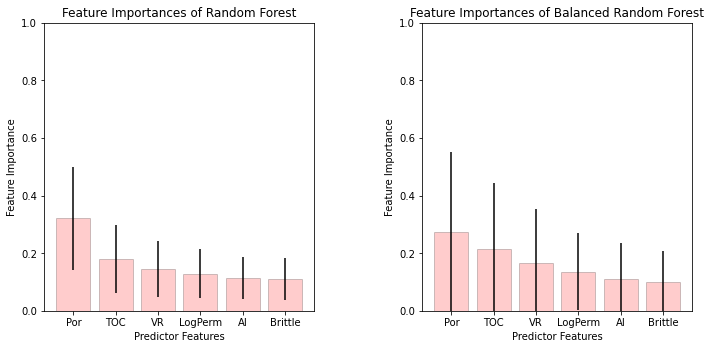

In [11]:
features = ['Por','TOC','VR','LogPerm','AI','Brittle']                       # names or predictor features

# feature importance plot for RF
importances = random_forest.feature_importances_               # expected (global) importance over the forest fore each predictor feature
std = np.std([tree.feature_importances_ for tree in random_forest.estimators_],axis=0) # retrieve importance by tree
indices = np.argsort(importances)[::-1]
features = ['Por','TOC','VR','LogPerm','AI','Brittle']                       # names or predictor features
for f in range(len(features)):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))
plt.subplot(121)
plt.title("Feature Importances of Random Forest")
plt.bar(features, importances[indices],color="red", alpha = 0.2, edgecolor = 'black', yerr=std[indices], align="center")
#plt.xticks(range(X.shape[1]), indices)
plt.ylim(0,1), plt.xlabel('Predictor Features'); plt.ylabel('Feature Importance')

### feature importance plot for balanced RF
importances = balanced_forest.feature_importances_               # expected (global) importance over the forest fore each predictor feature
std = np.std([tree.feature_importances_ for tree in balanced_forest.estimators_],axis=0) # retrieve importance by tree
indices = np.argsort(importances)[::-1]
for f in range(len(features)):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))
plt.subplot(122)
plt.title("Feature Importances of Balanced Random Forest")
plt.bar(features, importances[indices],color="red", alpha = 0.2, edgecolor = 'black', yerr=std[indices], align="center")
#plt.xticks(range(X.shape[1]), indices)
plt.ylim(0,1), plt.xlabel('Predictor Features'); plt.ylabel('Feature Importance')
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.5, top=1.0, wspace=0.4, hspace=0.2)


              precision    recall  f1-score   support

         0.0       0.97      1.00      0.98       284
         1.0       0.86      0.38      0.52        16

    accuracy                           0.96       300
   macro avg       0.91      0.69      0.75       300
weighted avg       0.96      0.96      0.96       300

              precision    recall  f1-score   support

         0.0       1.00      0.88      0.93       284
         1.0       0.30      0.94      0.45        16

    accuracy                           0.88       300
   macro avg       0.65      0.91      0.69       300
weighted avg       0.96      0.88      0.91       300



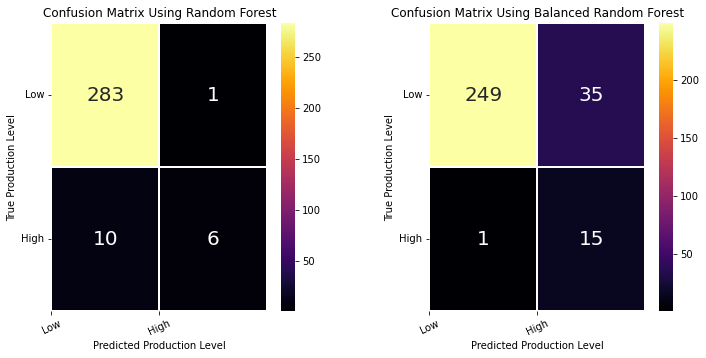

In [12]:
# classify using the test data
y_pred_test_rf = random_forest.predict(X_test)
y_pred_test_brf = balanced_forest.predict(X_test)


# plot the confusion matrix
plt.subplot(121)
plot_cmatrix('Random Forest', y_test, y_pred_test_rf, cmap).show
plt.subplot(122)
plot_cmatrix('Balanced Random Forest', y_test, y_pred_test_brf, cmap).show
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.5, top=1.0, wspace=0.4, hspace=0.2)

# print classification reports
print(classification_report(y_test, y_pred_test_rf))
print(classification_report(y_test, y_pred_test_brf))

The first summary statistics are derived from Random Forest and the second one from Balanced Random Forest. We can see that the precision of Random Forest is very low and also there is a low F1 score associated with high production, which indicates that the model was not careful to avoid classifying high production that are actually low production location. The take-away is that the Balanced Random Forest missed some low production locations to "trade-off" the classification accuracy of high production locations, i.e. when we aim to identify more high production wells, it is better to use a Balanced Random Forest model for a more biased data on low production dataset. 



I hope this was helpful,

Haoyu Wang

___________________

#### Work Supervised by:

### Michael Pyrcz, Associate Professor, University of Texas at Austin 
*Novel Data Analytics, Geostatistics and Machine Learning Subsurface Solutions*

With over 17 years of experience in subsurface consulting, research and development, Michael has returned to academia driven by his passion for teaching and enthusiasm for enhancing engineers' and geoscientists' impact in subsurface resource development. 

For more about Michael check out these links:

#### [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

#### Want to Work Together?

I hope this content is helpful to those that want to learn more about subsurface modeling, data analytics and machine learning. Students and working professionals are welcome to participate.

* Want to invite me to visit your company for training, mentoring, project review, workflow design and / or consulting? I'd be happy to drop by and work with you! 

* Interested in partnering, supporting my graduate student research or my Subsurface Data Analytics and Machine Learning consortium (co-PIs including Profs. Foster, Torres-Verdin and van Oort)? My research combines data analytics, stochastic modeling and machine learning theory with practice to develop novel methods and workflows to add value. We are solving challenging subsurface problems!

* I can be reached at mpyrcz@austin.utexas.edu.

I'm always happy to discuss,

*Michael*

Michael Pyrcz, Ph.D., P.Eng. Associate Professor The Hildebrand Department of Petroleum and Geosystems Engineering, Bureau of Economic Geology, The Jackson School of Geosciences, The University of Texas at Austin
